In [ ]:
import os
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchaudio.datasets import SPEECHCOMMANDS
from IPython.display import Audio, display

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# List of classes to use
CLASSES = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]



Using device: cuda


In [ ]:
# Helper to filter dataset by class
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        custom_path = r"D:\Python Projects\Envision Project\Dataset\speech_commands_v0.02"
        if os.path.exists(custom_path):
            print(f"Using dataset found at: {custom_path}")
            root = r"D:\Python Projects\Envision Project\Dataset"
            download = False
        else:
            print("Dataset not found at custom path, downloading to default location...")
            root = "./"
            download = True
        super().__init__(root=root, download=download)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as f:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in f]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

# Load datasets
try:
    train_set = SubsetSC("training")
    val_set = SubsetSC("validation")
    test_set = SubsetSC("testing")
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Attempting to download dataset to default location...")
    train_set = SubsetSC("training")
    val_set = SubsetSC("validation")
    test_set = SubsetSC("testing")
print(f"Train set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")



Dataset not found at custom path, downloading to default location...


100%|██████████| 2.26G/2.26G [00:20<00:00, 116MB/s]


Dataset not found at custom path, downloading to default location...
Dataset not found at custom path, downloading to default location...
Train set size: 84843
Validation set size: 9981


Sample rate: 16000
Waveform shape: torch.Size([1, 16000])
Label: down


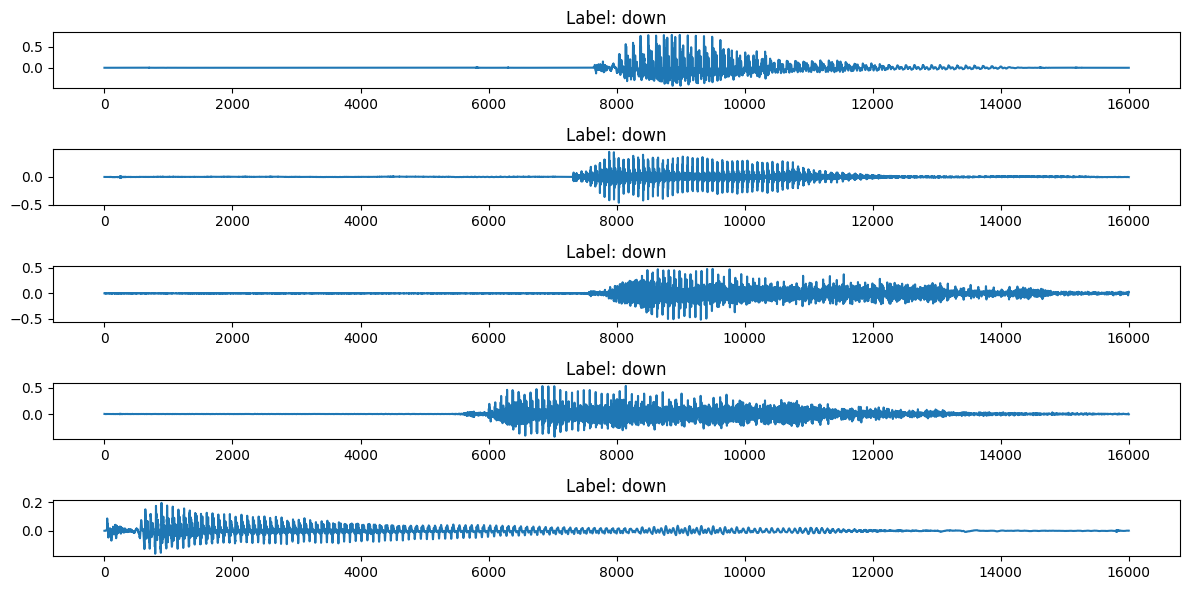

Label: down


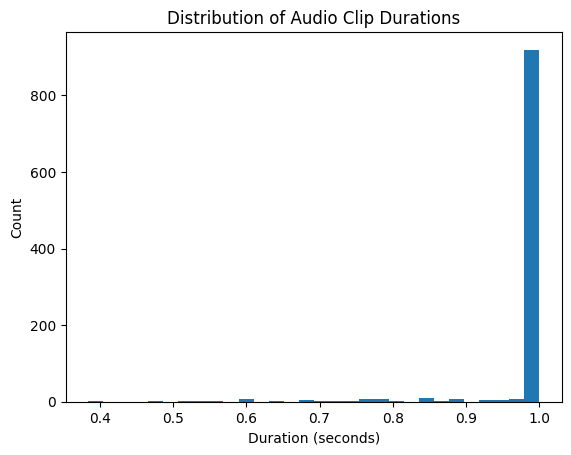

Min duration: 0.38s, Max duration: 1.00s, Mean: 0.98s


In [ ]:
# Filter samples to only include selected classes
def filter_classes(dataset, classes):
    indices = []
    for idx in range(len(dataset)):
        _, _, label, *_ = dataset[idx]
        if label in classes:
            indices.append(idx)
    return indices

train_indices = filter_classes(train_set, CLASSES)
val_indices = filter_classes(val_set, CLASSES)
test_indices = filter_classes(test_set, CLASSES)

# Check one sample
sample_waveform, sample_sr, sample_label, *_ = train_set[train_indices[0]]
print("Sample rate:", sample_sr)
print("Waveform shape:", sample_waveform.shape)
print("Label:", sample_label)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(train_indices[:5]):
    waveform, sr, label, *_ = train_set[idx]
    plt.subplot(5, 1, i+1)
    plt.plot(waveform.t().numpy())
    plt.title(f"Label: {label}")
plt.tight_layout()
plt.show()

waveform, sr, label, *_ = train_set[train_indices[0]]
print("Label:", label)
display(Audio(waveform.numpy(), rate=sr))

durations = []
for idx in train_indices[:1000]:
    waveform, sr, _, *_ = train_set[idx]
    durations.append(waveform.shape[1] / sr)
plt.hist(durations, bins=30)
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.title("Distribution of Audio Clip Durations")
plt.show()
print(f"Min duration: {min(durations):.2f}s, Max duration: {max(durations):.2f}s, Mean: {np.mean(durations):.2f}s")



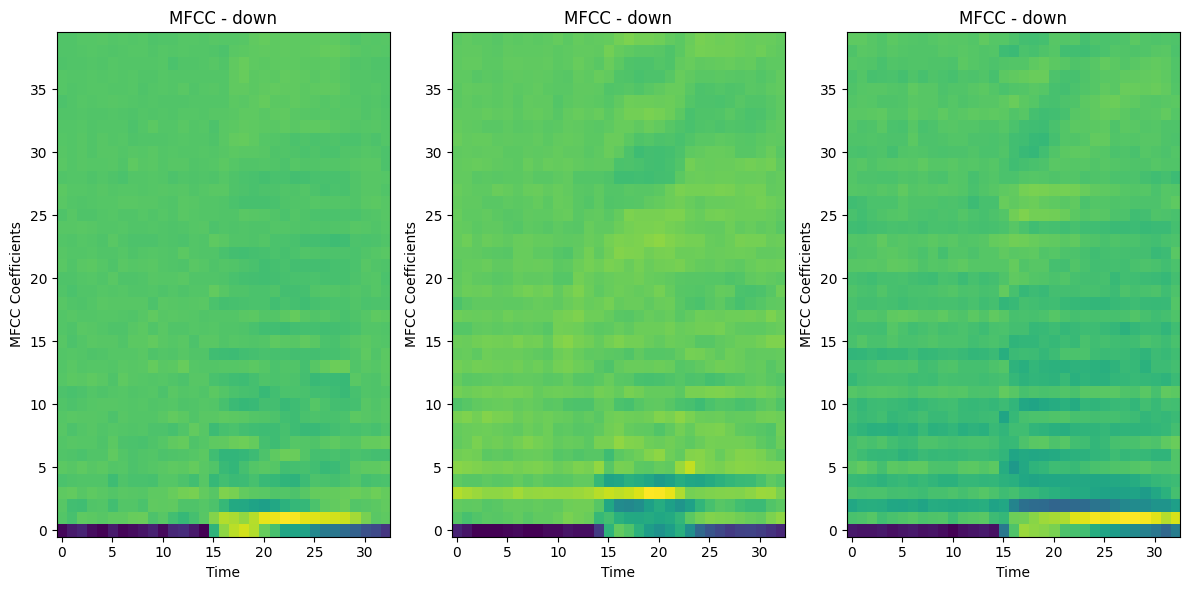

In [ ]:
# MFCC parameters
N_MFCC = 40
N_FFT = 1024
HOP_LENGTH = 500
N_MELS = 64

mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=sample_sr,
    n_mfcc=N_MFCC,
    melkwargs={"n_fft": N_FFT, "hop_length": HOP_LENGTH, "n_mels": N_MELS}
)

# Visualize MFCCs for a few samples
plt.figure(figsize=(12, 6))
for i, idx in enumerate(train_indices[:3]):
    waveform, sr, label, *_ = train_set[idx]
    mfcc = mfcc_transform(waveform)
    plt.subplot(1, 3, i+1)
    plt.imshow(mfcc[0].detach().numpy(), aspect='auto', origin='lower')
    plt.title(f"MFCC - {label}")
    plt.xlabel("Time")
    plt.ylabel("MFCC Coefficients")
plt.tight_layout()
plt.show()



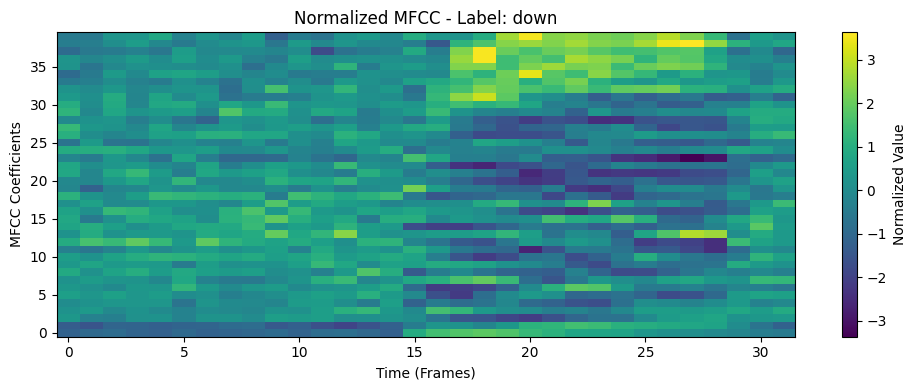

In [ ]:
# Set max sequence length manually
MAX_SEQ_LEN = 32

# Compute mean and std for normalization (on training set)
all_feats = []
for idx in train_indices[:1000]:  # Use a subset for speed
    waveform, _, label, *_ = train_set[idx]
    mfcc = mfcc_transform(waveform)[0].T
    if mfcc.shape[0] < MAX_SEQ_LEN:
        pad = torch.zeros(MAX_SEQ_LEN - mfcc.shape[0], mfcc.shape[1])
        mfcc = torch.cat([mfcc, pad], dim=0)
    else:
        mfcc = mfcc[:MAX_SEQ_LEN, :]
    all_feats.append(mfcc)
all_feats = torch.stack(all_feats)
mean = all_feats.mean(dim=(0, 1))
std = all_feats.std(dim=(0, 1))

# Custom dataset class
class SpeechCommandsDataset(Dataset):
    def __init__(self, base_dataset, indices, mfcc_transform, max_seq_len, class_list, mean=None, std=None):
        self.base_dataset = base_dataset
        self.indices = indices
        self.mfcc_transform = mfcc_transform
        self.max_seq_len = max_seq_len
        self.class_to_idx = {c: i for i, c in enumerate(class_list)}
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        idx = self.indices[i]
        waveform, _, label, *_ = self.base_dataset[idx]
        mfcc = self.mfcc_transform(waveform)[0].T  # (time, n_mfcc)
        if mfcc.shape[0] < self.max_seq_len:
            pad = torch.zeros(self.max_seq_len - mfcc.shape[0], mfcc.shape[1])
            mfcc = torch.cat([mfcc, pad], dim=0)
        else:
            mfcc = mfcc[:self.max_seq_len, :]
        if self.mean is not None and self.std is not None:
            mfcc = (mfcc - self.mean) / self.std
        return mfcc, self.class_to_idx[label]

# Create datasets with fixed MAX_SEQ_LEN = 32
train_ds = SpeechCommandsDataset(train_set, train_indices, mfcc_transform, MAX_SEQ_LEN, CLASSES, mean, std)
val_ds = SpeechCommandsDataset(val_set, val_indices, mfcc_transform, MAX_SEQ_LEN, CLASSES, mean, std)
test_ds = SpeechCommandsDataset(test_set, test_indices, mfcc_transform, MAX_SEQ_LEN, CLASSES, mean, std)

# Collate function
def collate_fn(batch):
    xs, ys = zip(*batch)
    xs = torch.stack(xs)
    ys = torch.tensor(ys)
    return xs, ys

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn)

# Example visualization of normalized MFCC
mfcc_feat, label_idx = train_ds[0]
plt.figure(figsize=(10, 4))
plt.imshow(mfcc_feat.T.numpy(), aspect='auto', origin='lower')
plt.title(f"Normalized MFCC - Label: {CLASSES[label_idx]}")
plt.xlabel("Time (Frames)")
plt.ylabel("MFCC Coefficients")
plt.colorbar(label="Normalized Value")
plt.tight_layout()
plt.show()


Epoch 1: Train Loss=1.7695, Val Loss=1.5901, Train Acc=0.3617, Val Acc=0.4564
Epoch 2: Train Loss=1.4203, Val Loss=1.2483, Train Acc=0.5065, Val Acc=0.5717
Epoch 3: Train Loss=1.1350, Val Loss=0.9619, Train Acc=0.6110, Val Acc=0.6573
Epoch 4: Train Loss=0.8891, Val Loss=0.8531, Train Acc=0.6952, Val Acc=0.7051
Epoch 5: Train Loss=0.7346, Val Loss=0.6431, Train Acc=0.7522, Val Acc=0.7913
Epoch 6: Train Loss=0.6432, Val Loss=0.6020, Train Acc=0.7893, Val Acc=0.8053
Epoch 7: Train Loss=0.5692, Val Loss=0.5443, Train Acc=0.8172, Val Acc=0.8274
Epoch 8: Train Loss=0.4870, Val Loss=0.4931, Train Acc=0.8469, Val Acc=0.8472
Epoch 9: Train Loss=0.4353, Val Loss=0.5195, Train Acc=0.8660, Val Acc=0.8307
Epoch 10: Train Loss=0.4088, Val Loss=0.4600, Train Acc=0.8710, Val Acc=0.8652


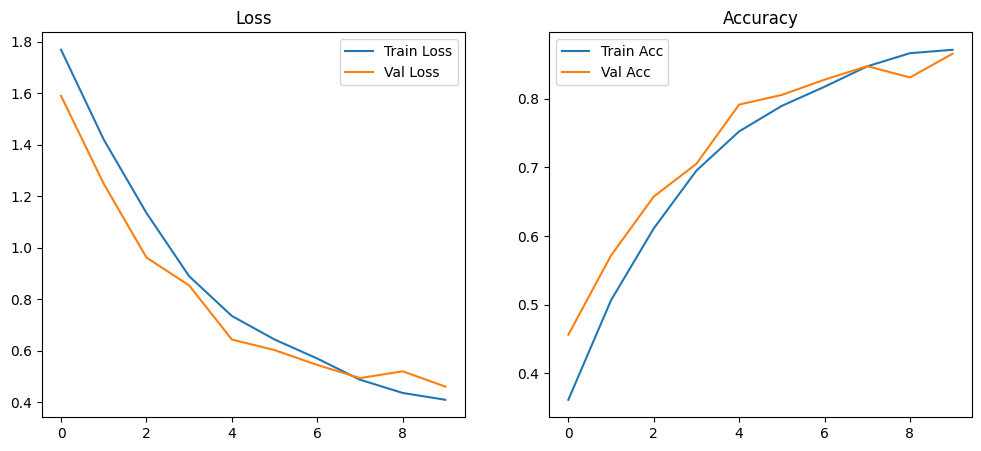

Test Loss: 0.5266, Test Accuracy: 0.8449


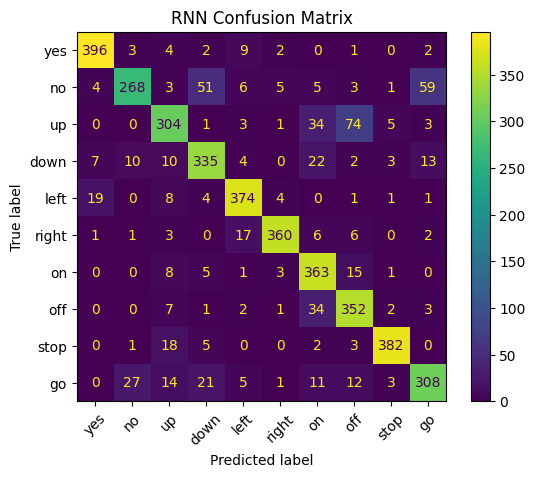

              precision    recall  f1-score   support

         yes       0.93      0.95      0.94       419
          no       0.86      0.66      0.75       405
          up       0.80      0.72      0.76       425
        down       0.79      0.83      0.81       406
        left       0.89      0.91      0.90       412
       right       0.95      0.91      0.93       396
          on       0.76      0.92      0.83       396
         off       0.75      0.88      0.81       402
        stop       0.96      0.93      0.94       411
          go       0.79      0.77      0.78       402

    accuracy                           0.84      4074
   macro avg       0.85      0.85      0.84      4074
weighted avg       0.85      0.84      0.84      4074



In [ ]:
import os
import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchaudio.datasets import SPEECHCOMMANDS
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from IPython.display import Audio, display

# Define the SimpleRNNClassifier model
class SimpleRNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.to(DEVICE)  # Ensure input is on correct device
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # Last time step
        return self.fc(out)

# Training function
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    return running_loss / total, correct / total

# Evaluation function
def eval_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            outputs = model(x)
            loss = criterion(outputs, y)
            running_loss += loss.item() * x.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return running_loss / total, correct / total

# Early Stopping Parameters
patience = 3  # Number of epochs to wait for improvement
best_val_acc = 0.0
epochs_without_improvement = 0

input_dim = N_MFCC
hidden_dim = 512
output_dim = len(CLASSES)
num_layers = 2
num_epochs = 10

# Initialize model, criterion, optimizer
rnn_model = SimpleRNNClassifier(input_dim, hidden_dim, output_dim, num_layers).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)  # Move criterion to device
optimizer = optim.Adam(rnn_model.parameters(), lr=1e-4)

train_losses, val_losses, train_accs, val_accs = [], [], [], []

# Training loop with early stopping
for epoch in range(num_epochs):
    tr_loss, tr_acc = train_epoch(rnn_model, train_loader, criterion, optimizer)
    va_loss, va_acc = eval_epoch(rnn_model, val_loader, criterion)
    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    train_accs.append(tr_acc)
    val_accs.append(va_acc)

    # Check if validation accuracy has improved
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        epochs_without_improvement = 0  # Reset counter
    else:
        epochs_without_improvement += 1

    # Print the current epoch results
    print(f"Epoch {epoch+1}: Train Loss={tr_loss:.4f}, Val Loss={va_loss:.4f}, Train Acc={tr_acc:.4f}, Val Acc={va_acc:.4f}")

    # Early stopping: If no improvement for 'patience' epochs, stop training
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered. No improvement in validation accuracy for {patience} epochs.")
        break

# Plot loss and accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.title("Accuracy")
plt.show()

# Test evaluation
test_loss, test_acc = eval_epoch(rnn_model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Confusion Matrix
all_preds, all_labels = [], []
rnn_model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE)
        outputs = rnn_model(x)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=CLASSES)
disp.plot(xticks_rotation=45)
plt.title("RNN Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(all_labels, all_preds, target_names=CLASSES))